# Mini Spark Broker: Filtering the stream

author: **Julien Peloton** [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2019-02-04


The purpose of this notebook is to test Spark filtering capability in the context of the DESC Broker design. 

**Useful Links:**

* https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html
* https://zwickytransientfacility.github.io/ztf-avro-alert/

In [1]:
from pyspark.sql import SparkSession

import io
import time

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from lsst.msb import avroUtils
from lsst.msb.filtering import make_dataframe_from_ztf
from lsst.msb.filtering import extract_history_ztf

## Step 0: Running the LSST alert system

In order to play with this notebook, you need to create the stream of alerts. see the README file of the bootcamp to set up your environment and launch the stream.

## Step 1: Connecting to the stream with Apache Spark

Once the stream is produced, let's initialise the Spark context:

In [2]:
# Grab the running Spark Session, 
# otherwise create it.
spark = SparkSession \
    .builder \
    .appName("filtering") \
    .getOrCreate()

Let's initialise a DataFrame that will read the stream from Kafka. Note that `kafka.bootstrap.servers` and `subscribe` must correspond to the arguments used for the LSST alert system (see above). At this point, we just create a Kafka Source for Streaming Queries - nothing really happens:

In [3]:
# Create a DF from the incoming stream from Kafka
# Note that <kafka.bootstrap.servers> and <subscribe>
# must correspond to arguments of the LSST alert system.
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9092") \
  .option("subscribe", "my-stream") \
  .option("startingOffsets", "earliest") \
  .load()

df.isStreaming

True

As you can see, `df` is a streaming Dataframe. You can start streaming computation, by defining the sink and starting it. 
<!-- In our case, we want to interactively query the counts (same queries as above), so we will set the complete set of 1 hour counts to be in a in-memory table (note that this for testing purpose only in Spark 2.0). -->

## Step 2: Filtering the stream

In this section, we will design simple fiters to interact with the stream and extract only relevant information for us. Let's first create a sink and grab all the alerts:

In [4]:
rawQuery = df\
    .writeStream \
    .queryName("qraw")\
    .format("memory")\
    .start()

In [5]:
# Give a bit of time for synchronisation
time.sleep(10)

In [6]:
# Construct your DataFrame with data from Kafka
df_raw = spark.sql("select * from qraw")
df_raw.show()

+----+--------------------+---------+---------+------+--------------------+-------------+
| key|               value|    topic|partition|offset|           timestamp|timestampType|
+----+--------------------+---------+---------+------+--------------------+-------------+
|null|[06 33 2E 32 32 5...|my-stream|        0|     0|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     1|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     2|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     3|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     4|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     5|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     6|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     7|2019-02-04 10:02:...|            0|
|null|[06 

We can look closely at the columns of this Dataframe:

In [7]:
df_raw.printSchema()
df_raw.describe().show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------+---------+---------+-----------------+-------------+
|summary|    topic|partition|           offset|timestampType|
+-------+---------+---------+-----------------+-------------+
|  count|     1497|     1497|             1497|         1497|
|   mean|     null|      0.0|            748.0|          0.0|
| stddev|     null|      0.0|432.2909899593097|          0.0|
|    min|my-stream|        0|                0|            0|
|    max|my-stream|        0|             1496|            0|
+-------+---------+---------+-----------------+-------------+



The column of interest for us is `value` which contains the alert data. For the moment, the data is `binary`, so let's decode it. First read the corresponding schema (ZTF in this example):

In [8]:
# Read the schema
alert_schema = avroUtils.readSchemaFromAvroFile("../schemas/template_schema_ZTF.avro")

# Broadcast the schema to all Spark executors
# (Keep in mind we work in a distributed environment!)
sc.broadcast(alert_schema)

# Look at the available keys
print(alert_schema.keys())

dict_keys(['type', 'version', 'name', 'namespace', 'fields', 'doc'])


Now we have the schema, we can decode the alerts. For technical reason, you need to go to RDD world to use in a meaningful way the decoder:

In [9]:
# RDD: Resilient Distributed Dataset.
# Both Spark DataFrames and RDDs are distributed memory abstractions, fault-tolerant and immutable.
# The main difference is that Dataframes are organized into named columns with defined 
# data types and including the benefits of Spark SQL's execution engine.
# Historically, there were only RDDs. DataFrame came later in Spark.
rdd_alerts = df_raw.select("value").rdd.map(lambda x: avroUtils.decoder(x.value, alert_schema))

And here is one full alert:

In [10]:
rdd_alerts.take(1)

[{'schemavsn': '3.2',
  'publisher': 'ZTF (www.ztf.caltech.edu)',
  'objectId': 'ZTF18abyouwp',
  'candid': 697251920015010010,
  'candidate': {'jd': 2458451.7519213,
   'fid': 1,
   'pid': 697251920015,
   'diffmaglim': 19.647123336791992,
   'pdiffimfilename': 'ztf_20181129251771_000248_zg_c01_o_q1_scimrefdiffimg.fits',
   'programpi': 'Kulkarni',
   'programid': 1,
   'candid': 697251920015010010,
   'isdiffpos': 'f',
   'tblid': 10,
   'nid': 697,
   'rcid': 0,
   'field': 248,
   'xpos': 1817.9852294921875,
   'ypos': 2753.298828125,
   'ra': 26.8566983,
   'dec': -26.9677112,
   'magpsf': 14.283452987670898,
   'sigmapsf': 0.038736678659915924,
   'chipsf': 50.48195266723633,
   'magap': 14.340100288391113,
   'sigmagap': 0.008100000210106373,
   'distnr': 0.24791085720062256,
   'magnr': 12.048999786376953,
   'sigmagnr': 0.012000000104308128,
   'chinr': 0.6589999794960022,
   'sharpnr': 0.032999999821186066,
   'sky': 0.5009307861328125,
   'magdiff': 0.05664699897170067,
   '

### My first filter

Let's see how we can filter the stream with Spark.
Previously, we built a RDD whose entries are alerts. You can directly play with the RDD, but probably Dataframes are more suited to simple analysis (and they benefit from several internal optimisation tools).

Let's build a DataFrame with some selected entries:

In [11]:
colnames = [
    "candidate:ra", "candidate:dec", 
    "candidate:magpsf", "candidate:sigmapsf", 
    "objectId", "cutoutScience:fileName"]
df_simple = make_dataframe_from_ztf(rdd_alerts, colnames)
df_simple.show(10)

+------------+-------------+------------------+--------------------+------------+----------------------+
|candidate:ra|candidate:dec|  candidate:magpsf|  candidate:sigmapsf|    objectId|cutoutScience:fileName|
+------------+-------------+------------------+--------------------+------------+----------------------+
|  26.8566983|  -26.9677112|14.283452987670898|0.038736678659915924|ZTF18abyouwp|  candid69725192001...|
|    26.24497|  -26.7569436|18.878799438476562| 0.20704418420791626|ZTF18acsbjqe|  candid69725192011...|
|  26.1126147|  -26.8053928|16.854799270629883| 0.17422600090503693|ZTF18acaixum|  candid69725192011...|
|  25.5844032|  -27.9239037| 18.25395393371582| 0.17449809610843658|ZTF18acsbjqg|  candid69725192021...|
|  25.5902591|  -27.9131274| 18.88495445251465|  0.1683504581451416|ZTF18acsbjqi|  candid69725192021...|
|  26.0145383|  -27.9003972|18.036954879760742| 0.13855810463428497|ZTF18acsbjqf|  candid69725192021...|
|  25.6648433|  -27.8417869|18.528953552246094| 0.18915

Let's apply a simple cut on the magnitude:

In [12]:
df_filtered = df_simple.filter(df_simple["candidate:magpsf"] < 16)
df_filtered.show(10)
print("Number of alerts: {}".format(df_filtered.count()))

+------------+-------------+------------------+--------------------+------------+----------------------+
|candidate:ra|candidate:dec|  candidate:magpsf|  candidate:sigmapsf|    objectId|cutoutScience:fileName|
+------------+-------------+------------------+--------------------+------------+----------------------+
|  26.8566983|  -26.9677112|14.283452987670898|0.038736678659915924|ZTF18abyouwp|  candid69725192001...|
|   23.517342|  -27.0446981| 15.95533275604248| 0.08913470059633255|ZTF18acsbjpf|  candid69725192051...|
|   23.439535|  -26.9757725|15.487110137939453|0.031102465465664864|ZTF18acsbjpe|  candid69725192051...|
|  21.6999741|  -26.3896297|15.393227577209473|  0.1148681566119194|ZTF18aceatmo|  candid69725192091...|
|  22.2083825|  -27.4846158|14.967976570129395| 0.07041992247104645|ZTF18acsbjpx|  candid69725192101...|
|  20.7232775|  -26.2927103|15.705092430114746| 0.06592856347560883|ZTF18abvrcvy|  candid69725192121...|
|  19.7900246|  -27.7713952|14.294271469116211|  0.0556

### Purity sample

The ZTF alert stream is rather raw, and they release [tips](https://zwickytransientfacility.github.io/ztf-avro-alert/filtering.html) to improve the purity of the sample based on some of the included attributes:

```
rb >= 0.65 and
nbad = 0 and
fwhm <= 5 and
elong <= 1.2 and
abs(magdiff) <= 0.1
```

Let's apply those filters:

In [13]:
colnames = [
    "candidate:rb", "candidate:nbad", "candidate:fwhm",
    "candidate:elong", "candidate:magdiff", "objectId"]
df_sub = make_dataframe_from_ztf(rdd_alerts, colnames)
print("Number of alerts (before): {}".format(df_sub.count()))

# Pipeline for purity
df_pure = df_sub\
    .filter(df_sub["candidate:rb"] >= 0.65)\
    .filter(df_sub["candidate:nbad"] == 0)\
    .filter(df_sub["candidate:fwhm"] <= 5.0)\
    .filter(df_sub["candidate:elong"] <= 1.2)\
    .filter("abs(`candidate:magdiff`) <= 0.1")

print("Number of alerts (after) : {}".format(df_pure.count()))

df_pure.show(10)

Number of alerts (before): 1497
Number of alerts (after) : 210
+------------------+--------------+------------------+------------------+--------------------+------------+
|      candidate:rb|candidate:nbad|    candidate:fwhm|   candidate:elong|   candidate:magdiff|    objectId|
+------------------+--------------+------------------+------------------+--------------------+------------+
|0.7200000286102295|             0|3.7100000381469727|1.0593219995498657| 0.08182000368833542|ZTF18abvdmcb|
|0.7599999904632568|             0| 2.950000047683716|1.0275423526763916|-0.00227200007066...|ZTF18abwpstw|
|0.8066666722297668|             0| 3.369999885559082|  1.05549955368042|0.044589001685380936|ZTF18acsbjpj|
|0.7799999713897705|             0| 3.680000066757202|1.0507662296295166|0.031189000234007835|ZTF18abvdmfx|
|0.7233333587646484|             0| 3.799999952316284|1.0986639261245728| 0.06438899785280228|ZTF18abvdmfw|
|0.7633333206176758|             0| 3.069999933242798| 1.088594675064087|

### Extracting light curves from previous candidates

Previous subtraction candidates at the position of the alert candidate are also stored with new candidate alert. You can therefore extract information over time. A good candidate is the evolution of the magnitude over time:

In [14]:
# Pipeline to extract light curve.
light_curves = (
    rdd_alerts
    # Improve the purity of the sample
    .filter(lambda x: x["candidate"]["rb"] >= 0.65)
    .filter(lambda x: x["candidate"]["nbad"] == 0)
    .filter(lambda x: x["candidate"]["fwhm"] <= 5.0)
    .filter(lambda x: x["candidate"]["elong"] <= 1.2)
    .filter(lambda x: abs(x["candidate"]["magdiff"]) <= 0.1)
    # Extract information over time
    .map(
        lambda x: (
            extract_history_ztf(x, "magpsf"),
            extract_history_ztf(x, "sigmapsf"),
            extract_history_ztf(x, "diffmaglim"),
            extract_history_ztf(x, "jd"),
            extract_history_ztf(x, "fid")
        )
    )
)

# Transfer 20 first alerts
list_light_curves = light_curves.take(9)

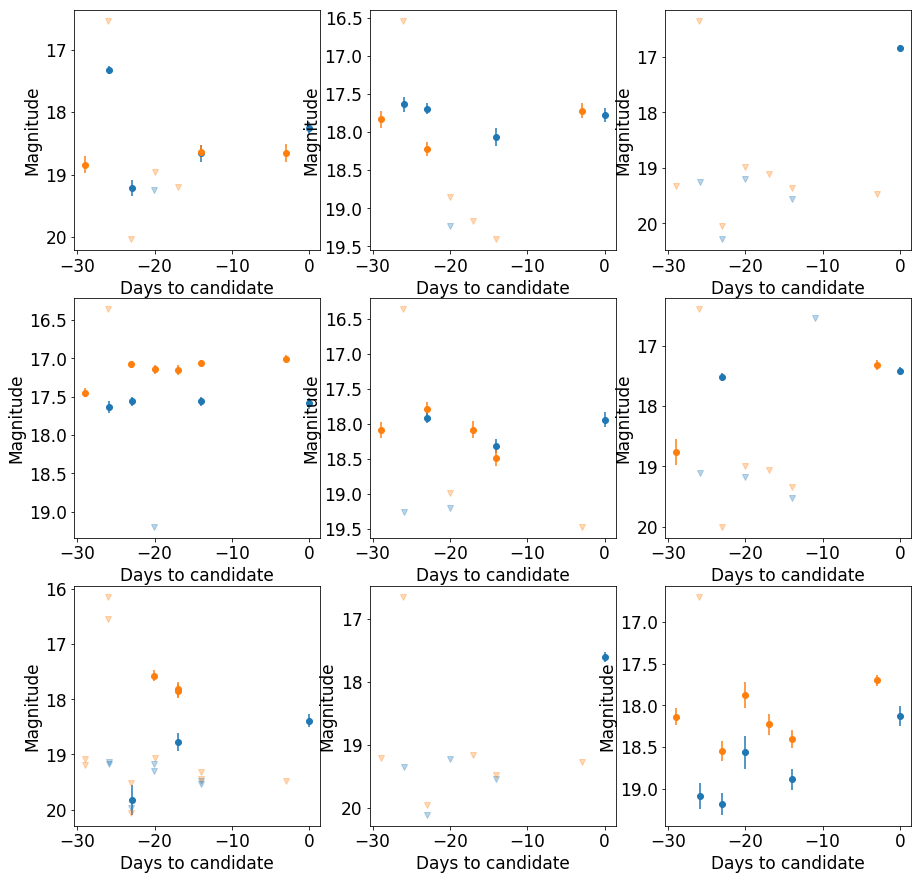

In [15]:
matplotlib.rcParams.update({'font.size': 17})

# Plot the light curves
fig = plt.figure(figsize=(15, 15))

# Assign different colors to filters
filter_color = {1:'C0', 2:'C1', 3:'C2'}

# Loop over the alerts
for index_lc, lc in enumerate(list_light_curves[:9]):
    ax = fig.add_subplot(3, 3, index_lc+1)
    
    # Unpack the lists
    mag, sig, ulim, jd, fid = lc
    
    # Determine detection vs upper limits
    det = [True if i is not None else False for i in sig]
    
    # Label date from the last alert
    dates = [i - jd[0] for i in jd]
    
    # Color/marker/blending
    colors = [filter_color[i] for i in fid]
    ma = ["o" if i is True else "v" for i in det]
    alpha = [1 if i is True else 0.3 for i in det]
    
    # Plot point-by-point
    for d, m, s, u, c, ma, a in zip(dates, mag, sig, ulim, colors, ma, alpha):
        if d is None:
            continue
        if a == 1:
            ax.errorbar(d, m, s, ls="", marker=ma, color=c, alpha=a)
        else:
            ax.plot(d, u, ls="", marker=ma, color=c, alpha=a)

    # plt.ylim(14, 20)
    plt.xlabel("Days to candidate")
    plt.ylabel("Magnitude")
    plt.gca().invert_yaxis()

### Your filters!

Now it's time for you to implement your filters! You can have a look at [ZTF avro schema](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html) to know the different alert attributes.

Obviously we implemented only simple filters here - and the goal now is to make more complex pipelines to maximize the scientific return!